## Description:

This file contains:
* Using saved model file:
    * predict on unseen 600k non-sub fvids
    * eda on their behavior

In [1]:
"""Helper"""
import pandas as pd
import numpy as np
import time
import joblib
from joblib import parallel_backend

"""Visualization"""
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

'''Modeling'''
import lightgbm as lgb

'''GCS Utils'''
from gcs_utils import *

'''Modeling Helpers'''
from sklearn.metrics import (f1_score, 
                             auc, 
                             classification_report, 
                             accuracy_score, 
                             confusion_matrix, 
                             plot_confusion_matrix, 
                             precision_recall_curve, 
                             recall_score,
                             precision_score,
                             roc_curve, 
                             roc_auc_score)

SEED = 42

* **Read serialized objects**

In [2]:
# load model
lgbm_model = joblib.load("./pv1_files/pv1_lgbm_model.joblib")
print(lgbm_model)

# load serialized objects
feat_selected = joblib.load("./pv1_files/pv1_feat_selected.joblib")
print(len(feat_selected))

scaler = joblib.load("./pv1_files/pv1_scaler.joblib")

LGBMClassifier(random_state=42)
59


* **Raw data**

In [3]:
# read data
raw_pred_data = pd.read_csv("../data/pred_ns_pv1_data_01132022.csv")

# convert fvid column from float to object
raw_pred_data.ga_fullvisitorid = raw_pred_data.ga_fullvisitorid.map(lambda x: '{:.0f}'.format(x)) 

* **Show data**

In [4]:
pred_set = raw_pred_data.copy()
print("Any NAs?: ", pred_set.columns[pred_set.isna().any()])

print("Shape:", pred_set.shape)
print()

# fill any Nulls with 0

pred_set.fillna(0, inplace=True)

# drop unnecessary cols
cols_to_drop = [x for x in pred_set.columns if 'other' in x] + ['ga_fullvisitorid']

pred_set = pred_set.drop(cols_to_drop, 
             axis=1)

pred_set.head()

Any NAs?:  Index([], dtype='object')
Shape: (699887, 613)



,session_pvs_mean,session_pvs_median,session_top_mean,session_top_median,bounce_rate,content_views_rate,rf_content_aggregators,rf_direct,rf_newsletter,rf_organic_search,...,minute_50_top,minute_51_top,minute_52_top,minute_53_top,minute_54_top,minute_55_top,minute_56_top,minute_57_top,minute_58_top,minute_59_top
0,1.00,1.00,2.15,0.00,1.00,1.00,13.00,0.00,0.00,0.00,...,0.00,0.00,13.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.00,1.00,51.67,42.00,1.00,1.00,0.00,0.00,0.00,3.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,42.00
2,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1.00,1.00,476.00,476.00,1.00,1.00,0.00,0.00,0.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1.50,1.50,24.00,24.00,0.50,1.00,0.00,0.00,0.00,3.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### Apply treatments/transformations on pred set to make it model-ready

In [5]:
print("before FS: ", pred_set.shape)

# ---FEATURE SELECT---
pred_set = pred_set[feat_selected]

print("after FS: ", pred_set.shape)

before FS:  (699887, 605)
after FS:  (699887, 59)


In [6]:
# define col names

t1_pv_cols =        [col for col in pred_set.columns if ('t1_' in col) & ('_pvs' in col)]
t1_top_cols =       [col for col in pred_set.columns if ('t1_' in col) & ('_top' in col)]
t2_pv_cols =        [col for col in pred_set.columns if 't2_' in col]
pc_cols =           [col for col in pred_set.columns if 'pc_' in col]
ps_cols =           [col for col in pred_set.columns if 'ps_' in col]
deviceos_cols =     [col for col in pred_set.columns if 'dos_' in col]
referral_cols =     [col for col in pred_set.columns if 'rf_' in col]
country_cols =      [col for col in pred_set.columns if 'ct_' in col]

wk_pv_cols =        [col for col in pred_set.columns if ('week' in col) & ('_pvs' in col)]
wk_top_cols =       [col for col in pred_set.columns if ('week' in col) & ('_top' in col)]
busi_pv_cols =      [col for col in pred_set.columns if ('business_hours' in col) & ('_pvs' in col)]
busi_top_cols =     [col for col in pred_set.columns if ('business_hours' in col) & ('_top' in col)]
dom_cols =          [col for col in pred_set.columns if 'day_of_mon_' in col] 
hour_cols =         [col for col in pred_set.columns if 'hour_' in col] 
minute_cols =       [col for col in pred_set.columns if 'minute_' in col]

# remove mis-assigned ones
pc_cols.remove('t2_pc_games_pvs')

categorical_cols = (t1_pv_cols +  t1_top_cols + t2_pv_cols + pc_cols + ps_cols + deviceos_cols + referral_cols + country_cols +
                    wk_pv_cols + wk_top_cols + busi_pv_cols + busi_top_cols + dom_cols + hour_cols + minute_cols 
                   )

print(len(categorical_cols))

numerical_cols = ['session_pvs_mean', 'session_top_mean', 'bounce_rate', 'content_views_rate']

print(len(numerical_cols))

# ---NORMALIZE---

from sklearn.preprocessing import normalize

def normalize_pvs(col_list):
    pred_set[col_list] = normalize(pred_set[col_list], norm='l1', axis=1)

normalize_pvs(t1_pv_cols)
normalize_pvs(t2_pv_cols)
normalize_pvs(pc_cols)
normalize_pvs(ps_cols)
normalize_pvs(referral_cols)
normalize_pvs(country_cols)
normalize_pvs(wk_pv_cols)


# ---SCALE---
col_list = pred_set.columns

pred_set = pd.DataFrame(scaler.transform(pred_set), columns = col_list)

48
4


* **Prediction set data**
    * eligible people = random sample of 700k non-sub fvids with greater than 1 pv in Dec '21
        * who were not present in our training subs or non-subs fvids <br><br>
    
    * their GA data:
        *  users' activity between 1-Oct-2021 and 31-Dec-2021 - 90 days

In [7]:
pred_set

,bounce_rate,business_hours_pvs,business_hours_top,content_views_rate,ct_united_states,friday_top,monday_top,non_business_hours_pvs,non_business_hours_top,pc_billionaires_pvs,...,t2_industries_pvs,t2_pc_games_pvs,t2_personal_investing_pvs,thursday_top,tuesday_top,wednesday_top,weekday_pvs,weekday_top,weekend_pvs,weekend_top
0,0.47,-0.01,-0.57,0.34,0.61,-0.32,-0.33,-0.04,-0.54,1.10,...,-0.40,-0.19,2.95,-0.37,-0.37,-0.31,0.17,-0.65,-0.17,-0.44
1,0.47,-0.15,-0.58,0.34,-1.64,0.04,-0.38,-0.10,0.03,-0.15,...,-0.40,-0.19,-0.38,0.66,-0.37,-0.37,0.86,-0.27,-0.86,-0.44
2,0.47,-0.15,-0.58,0.34,0.61,-0.36,-0.38,-0.13,-0.57,-0.15,...,-0.40,-0.19,-0.38,-0.37,-0.37,-0.37,-2.14,-0.67,2.14,-0.44
3,0.47,-0.16,-0.58,0.34,-1.64,1.91,-0.38,-0.10,1.26,-0.15,...,-0.40,-0.19,-0.38,-0.37,-0.37,-0.37,0.86,1.17,-0.86,-0.44
4,-1.44,-0.11,-0.33,0.34,0.61,-0.36,-0.38,-0.15,-0.57,-0.15,...,-0.40,5.44,-0.38,-0.37,-0.07,-0.37,0.86,-0.42,-0.86,-0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699882,0.47,-0.11,-0.36,0.34,0.61,-0.36,-0.38,-0.13,1.34,7.96,...,-0.40,-0.19,-0.38,1.90,-0.37,-0.37,-1.39,1.25,1.39,-0.21
699883,0.47,-0.16,-0.58,0.34,-1.64,-0.36,-0.16,-0.10,-0.42,-0.15,...,-0.40,-0.19,-0.38,-0.37,-0.37,-0.37,-0.64,-0.48,0.64,-0.33
699884,0.07,-0.11,-0.49,0.34,0.61,-0.25,0.71,0.37,1.20,-0.15,...,2.81,-0.19,-0.38,-0.37,-0.15,2.60,0.04,0.17,-0.04,3.28
699885,0.47,-0.15,0.07,0.34,0.61,0.43,-0.38,-0.07,-0.53,-0.15,...,-0.40,-0.19,-0.38,-0.37,-0.37,-0.37,-0.64,-0.35,0.64,-0.39


* **Model predict**

In [8]:
preds = lgbm_model.predict(pred_set)

print("Predicted distribution:")
print(pd.Series(preds).value_counts())
print()
print("% Subscribers:", round(len(preds[preds==1])/len(preds)*100)) 

Predicted distribution:
0    692076
1      7811
dtype: int64

% Subscribers: 1


In [9]:
7811/(7811+692076)

# In 1 month, >1pv folks people = 4MM+ so model will roughly flag 40k people as subs for targeting

0.011160373031646537

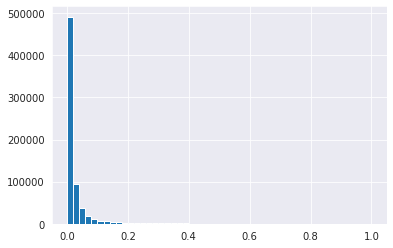

In [10]:
preds_probs = lgbm_model.predict_proba(pred_set)[:,1]
plt.hist(preds_probs, bins=50)
plt.show()

7811


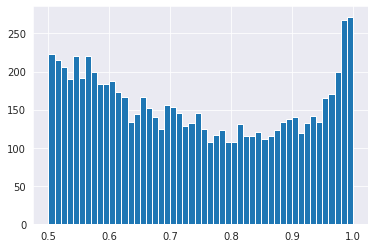

In [11]:
print(len(preds_probs[preds_probs>0.5]))

plt.hist(preds_probs[preds_probs>0.5], bins=50)
plt.show()

In [ ]:
# probability calibration 
# move to 0.6 or 0.9
# 
# indexing eda

#### EDA on predicted results

In [13]:
raw_pred_data["predictions"] = preds

raw_pred_data["predicted_class"] = np.where(raw_pred_data["predictions"]==1, 'Subs', 'Non-Subs')

raw_pred_data.predictions.value_counts()

0    692076
1      7811
Name: predictions, dtype: int64

* Average of (unique pageviews in each sessions)

    * **Same as training** - Avg. pv per session is more for subs

In [14]:
raw_pred_data.groupby('predicted_class')['session_pvs_mean'].describe().T

predicted_class,Non-Subs,Subs
count,692076.00,7811.00
mean,1.05,1.44
std,0.20,0.66
min,1.00,1.00
25%,1.00,1.00
50%,1.00,1.25
75%,1.00,1.50
max,7.50,12.00


* Average and Median of (sum of time on page in each session)

    * **Same as training** - Both avg and median distributions for subs are higher than non-subs

In [17]:
raw_pred_data.groupby('predicted_class')[['session_top_mean', 'session_top_median']].describe().T

predicted_class           Non-Subs    Subs
session_top_mean   count 692076.00 7811.00
                   mean     134.70  189.22
                   std      269.68  247.75
                   min        0.00    0.00
                   25%       15.00   58.50
                   50%       45.50  113.62
                   75%      117.50  226.25
                   max     5838.00 6454.00
session_top_median count 692076.00 7811.00
                   mean     120.67  141.34
                   std      268.99  246.92
                   min        0.00    0.00
                   25%        8.00   27.00
                   50%       33.00   66.00
                   75%       94.50  149.00
                   max     5838.00 6454.00

In [18]:
def eda(data, columns):
    
    # drop 'other' column
    columns = [x for x in columns if 'other' not in x]
    
    # groupby - calculate sum of pageviews in each category - calculate percentage
    eda_df = data.groupby('predicted_class')[columns].sum().apply(lambda x: (x/x.sum())*100,
                                                                  axis=1).T.sort_values('Subs', ascending=False)
    #rename
    eda_df = eda_df.rename(columns={"Subs": "% of Subs pvs", "Non-Subs": "% of Non-Subs pvs"})

    #calculate rank
    eda_df['Subs_rank'] = eda_df['% of Subs pvs'].rank(ascending=False).astype(int)
    eda_df['NonSubs_rank'] = eda_df['% of Non-Subs pvs'].rank(ascending=False).astype(int)
    
    return eda_df


# make categorical cols
referral_cols =     [col for col in raw_pred_data.columns if 'rf_' in col]
country_cols =      [col for col in raw_pred_data.columns if 'ct_' in col]
deviceos_cols =     [col for col in raw_pred_data.columns if 'dos_' in col]

t1_pv_cols =        [col for col in raw_pred_data.columns if ('t1_' in col) & ('_pvs' in col)]
t2_pv_cols =        [col for col in raw_pred_data.columns if 't2_' in col]
pc_cols =           [col for col in raw_pred_data.columns if 'pc_' in col]
ps_cols =           [col for col in raw_pred_data.columns if 'ps_' in col]

# remove mis-assigned ones
pc_cols.remove('t2_pc_games_pvs')
ps_cols.remove('t1_family_and_relationships_pvs')
ps_cols.remove('t1_family_and_relationships_top')
ps_cols.remove('t2_apprenticeships_pvs')
ps_cols.remove('t2_celebrity_relationships_pvs')

### Pageviews in referral sources, country, device OS

* **Same as training**
    * Subs more from organic search, referral, social, newsletter
    * Non-subs more from content aggregators, direct
    
* **Differs** 
    * Compared to training data
        * Subs % pvs much more in direct 
        * Subs % pvs in content aggregators higher than social (forbes and dark)
        
            * Maybe cz these folks are currently non-subs so coming from these channels but model predicted = high propensity to sub given overall behavior

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
rf_organic_search,53.36,54.06,1,1
rf_direct,15.81,25.24,2,3
rf_content_aggregators,29.03,6.95,3,2
rf_referral,0.21,6.80,4,5
rf_organic_social_dark,1.51,4.33,5,4
rf_organic_social_forbes,0.05,1.81,6,6
rf_newsletter,0.00,0.56,7,11
rf_push_notification,0.00,0.20,8,9
rf_paid_search,0.03,0.05,9,7
rf_paid_display,0.00,0.00,10,10


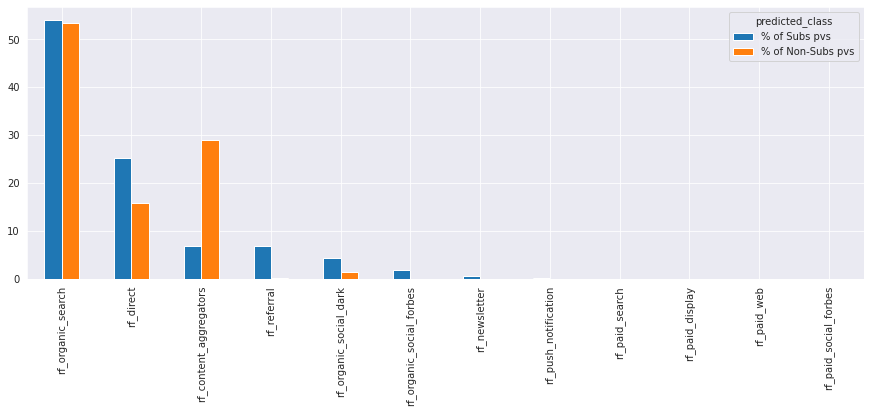

In [19]:
eda(raw_pred_data, referral_cols)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, referral_cols)

* **Same as training**
    * Subs highest in US.
    * Non-subs presence is in other countries also

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
ct_united_states,75.86,83.66,1,1
ct_canada,8.11,6.24,2,2
ct_india,2.38,3.35,3,5
ct_united_kingdom,7.17,2.56,4,3
ct_australia,4.37,1.48,5,4
ct_philippines,0.65,0.92,6,7
ct_singapore,0.84,0.88,7,6
ct_japan,0.11,0.37,8,9
ct_russia,0.06,0.30,9,10
ct_germany,0.45,0.24,10,8


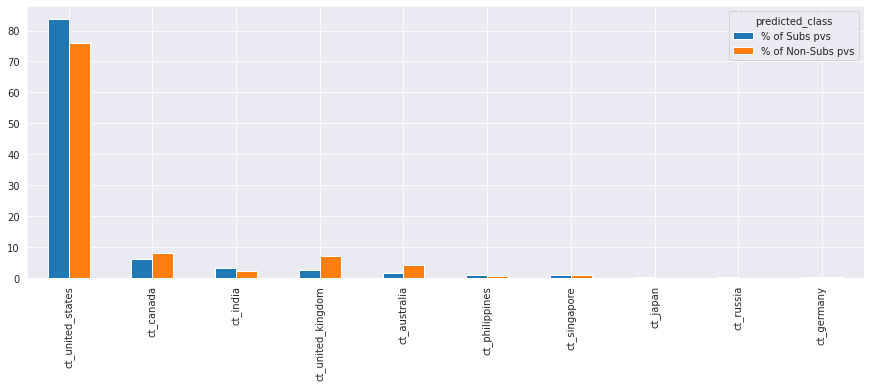

In [20]:
eda(raw_pred_data, country_cols)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, country_cols)

* **Differs** 
    * Predicted subs have far less pvs from desktop compared to phone 
        * (they are currenlty non-subs coming from phones more but have overall reading behavior like subs?)

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
dos_android,55.04,61.80,1,1
dos_ios,44.60,35.99,2,2
dos_windows,0.07,1.40,3,4
dos_macintosh,0.29,0.81,4,3


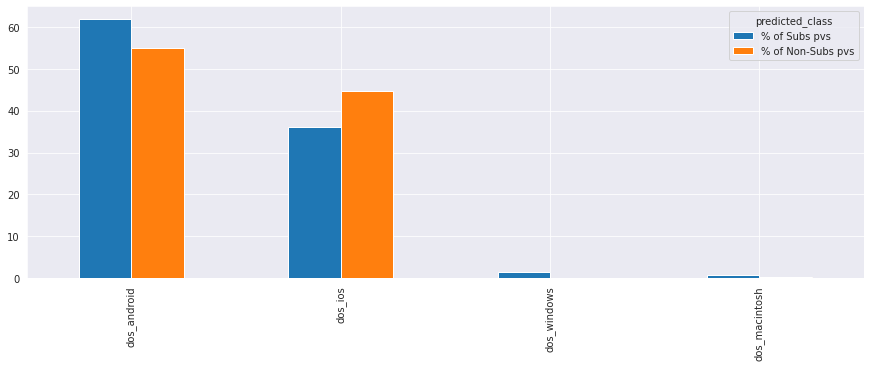

In [22]:
eda(raw_pred_data, deviceos_cols)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, deviceos_cols)

* **Same as training**
    * Mostly all same
    
* **Differs** 
    * Subs have slighlty more pvs in Personal Finance
    * Predicted subs also reading video game (more %pvs than training data)

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
t1_business_and_finance_pvs,17.07,25.34,1,2
t1_personal_finance_pvs,12.73,17.11,2,4
t1_technology_and_computing_pvs,17.23,10.29,3,1
t1_video_gaming_pvs,12.75,7.47,4,3
t1_news_and_politics_pvs,8.22,6.61,5,5
t1_medical_health_pvs,7.97,4.42,6,6
t1_sports_pvs,3.11,2.62,7,7
t1_automotive_pvs,1.56,2.62,8,12
t1_music_and_audio_pvs,1.33,2.24,9,15
t1_travel_pvs,2.00,2.13,10,10


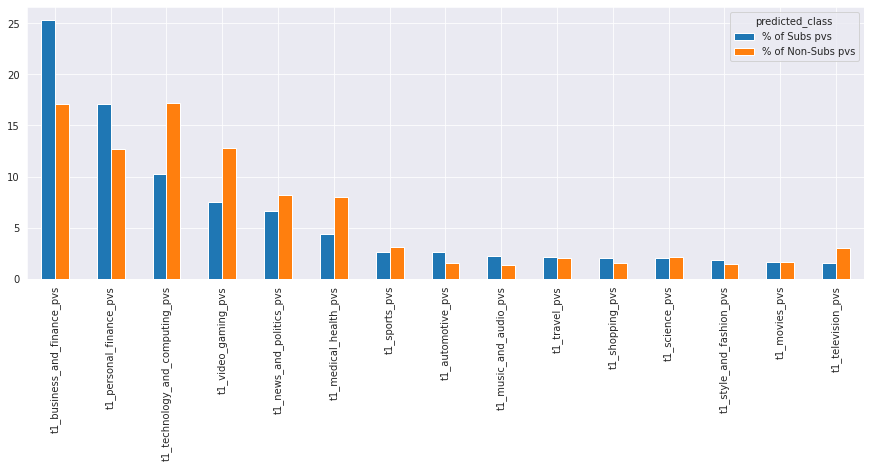

In [23]:
eda(raw_pred_data, t1_pv_cols).head(15)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, t1_pv_cols).head(15)

* **Same as training**
    * Mostly same 
    
* **Differs** 
    * Subs have slighlty more pvs in PC Games, Personal Debt 
    * Predicted subs not coming for disease and condition content as much compared to training

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
t2_economy_pvs,12.64,10.82,1,1
t2_business_pvs,2.81,10.80,2,12
t2_personal_debt_pvs,7.21,8.29,3,3
t2_computing_pvs,11.23,7.25,4,2
t2_personal_investing_pvs,4.13,5.51,5,8
t2_industries_pvs,2.86,5.21,6,11
t2_pc_games_pvs,5.04,5.02,7,6
t2_consumer_electronics_pvs,6.92,3.12,8,4
t2_politics_pvs,4.03,2.91,9,9
t2_diseases_and_conditions_pvs,4.58,2.60,10,7


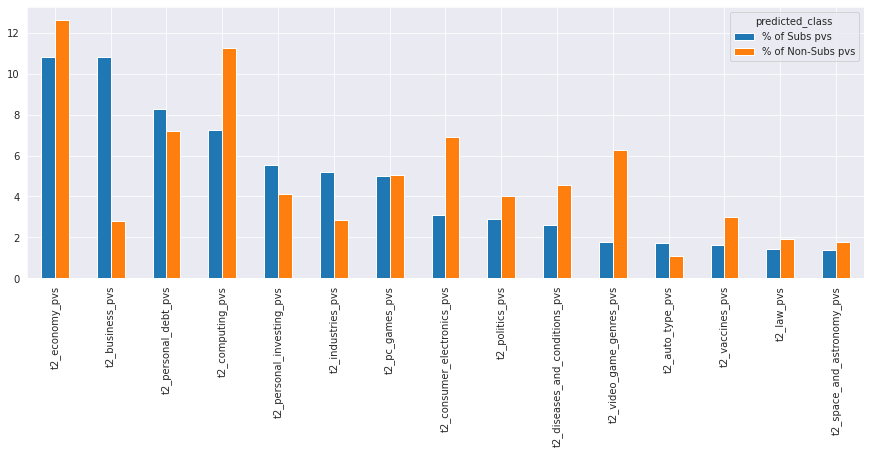

In [25]:
eda(raw_pred_data, t2_pv_cols).head(15)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, t2_pv_cols).head(15)

* **Same as training**
    * Leadership, small business, billionaires, innovation imp
    * Mostly all same
    
* **Differs** 
    * Subs slightly less % pvs in Business

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
pc_money_pvs,25.83,27.51,1,2
pc_innovation_pvs,40.68,22.82,2,1
pc_business_pvs,20.27,19.22,3,3
pc_leadership_pvs,2.96,12.83,4,5
pc_lifestyle_pvs,6.49,7.84,5,4
pc_small_business_pvs,1.08,2.85,6,6
pc_billionaires_pvs,0.66,2.26,7,7
pc_home_pvs,0.01,1.20,8,19
pc_asia_pvs,0.57,1.16,9,9
pc_real_estate_pvs,0.61,0.99,10,8


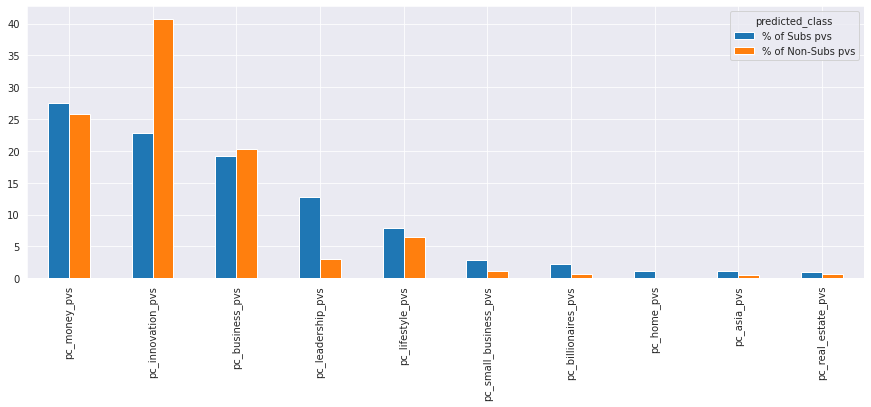

In [26]:
eda(raw_pred_data, pc_cols).head(10)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, pc_cols).head(10)

* **Same as training**
    * Games, tech, leadership, careers, forbes women, crypto = same 
    
* **Differs** 
    * Top 5 % pvs for subs not ideal. 
    * But subs % pvs still make sense compared to non-subs

predicted_class,% of Non-Subs pvs,% of Subs pvs,Subs_rank,NonSubs_rank
ps_crypto_and_blockchain_pvs,14.05,12.54,1,2
ps_personal_finance_pvs,9.11,10.71,2,4
ps_games_pvs,18.54,9.53,3,1
ps_consumer_tech_pvs,12.90,6.78,4,3
ps_hollywood_and_entertainment_pvs,3.76,5.68,5,7
ps_careers_pvs,1.02,3.92,6,18
ps_leadership_strategy_pvs,0.81,3.30,7,20
ps_markets_pvs,1.71,3.06,8,13
ps_science_pvs,3.67,2.95,9,8
ps_travel_pvs,2.75,2.83,10,10


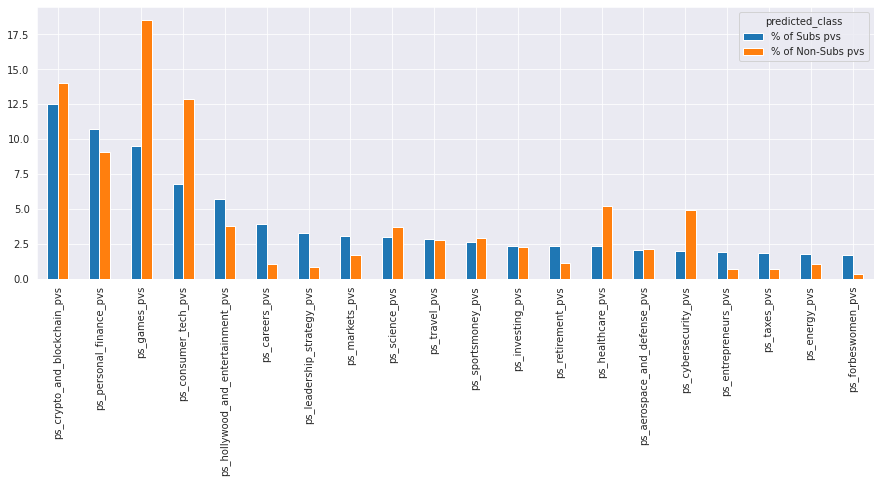

In [27]:
eda(raw_pred_data, ps_cols).head(20)[["% of Subs pvs", "% of Non-Subs pvs"]].plot(kind='bar', figsize=(15,5))

eda(raw_pred_data, ps_cols).head(20)

* **Same as training** - Non-Subs more

In [28]:
raw_pred_data.groupby('predicted_class')['bounce_rate'].describe().T

predicted_class,Non-Subs,Subs
count,692076.00,7811.00
mean,0.95,0.71
std,0.19,0.32
min,0.00,0.00
25%,1.00,0.60
50%,1.00,0.80
75%,1.00,1.00
max,1.00,1.00


* **Same as training** - Non-Subs more

In [29]:
raw_pred_data.groupby('predicted_class')['content_views_rate'].describe().T

predicted_class,Non-Subs,Subs
count,692076.00,7811.00
mean,1.00,0.92
std,0.01,0.17
min,0.33,0.00
25%,1.00,0.90
50%,1.00,1.00
75%,1.00,1.00
max,1.00,1.00


In [ ]:
# next steps